###The health of a connection on a local network or the larger Internet, and is commonly utilized by network administrators to diagnose the speed and reliability of network connections with help of TCP and RTT

In [1]:
#import drive from google
#from google.colab import drive

In [2]:
# mount the drive
#drive.mount("/content/drive")

In [3]:
#import the liabaries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
 #read the data from google drive
df =pd.read_csv("cleanedtelecomunication_df.csv")
df.head()

,BearerId,MSISDNNumber,Duration_Seconds,AvgRTT_DL,AvgRTT_UL,AvgBearerTP_DL,AvgBearerTP_UL,TCPDLRetransVol_Bytes,TCPULRetransVol_Bytes,GamingDL_Bytes,YoutubeUL_Bytes,YoutubeDL_Bytes,NetflixUL_Bytes,Total_Data,Total_DL,Total_UL,NetflixDL_Bytes,OtherUL_Bytes,OtherDL_Bytes,GamingUL_Bytes
0,1.311450e+19,3.368542e+10,243.504,45.0,5.0,28.0,41.0,568730.0,20949.5,519620584.0,14644405.0,17400892.0,20806551.0,599743023.0,556406594.0,43336429.0,7682779.0,3820483.0,318297673.0,2710989.0
1,1.311450e+19,3.366132e+10,236.570,46.0,7.0,46.0,46.0,568730.0,20949.5,715350506.0,16964908.0,19431593.0,9907089.0,798245704.0,757526492.0,40719212.0,11758420.0,1716480.0,290582586.0,10250922.0
2,1.311450e+19,3.361513e+10,231.780,45.0,5.0,23.0,51.0,568730.0,20949.5,124180544.0,13154981.0,7438887.0,9887128.0,192095344.0,139043208.0,53052136.0,753238.0,14932623.0,350039548.0,14967821.0
3,1.311450e+19,3.366495e+10,230.839,39.0,2.0,22.0,46.0,568730.0,20949.5,293492651.0,14454366.0,3334865.0,1530332.0,359872820.0,329159454.0,30713366.0,17917894.0,11684759.0,495376623.0,1362536.0
4,7.349880e+18,3.366403e+10,238.915,38.0,1.0,49.0,47.0,568730.0,20949.5,516508263.0,21457678.0,23039020.0,13958301.0,604428354.0,546747900.0,57680454.0,1114842.0,9207067.0,624397048.0,8432981.0


In [5]:
df.shape

(65571, 20)

###Create the Box Plot to find the outliers

In [6]:
columns = ['AvgRTT_DL', 'AvgRTT_UL', 'AvgBearerTP_DL', 'AvgBearerTP_UL', 'TCPDLRetransVol_Bytes', 'TCPULRetransVol_Bytes']
df_selected = df[columns]

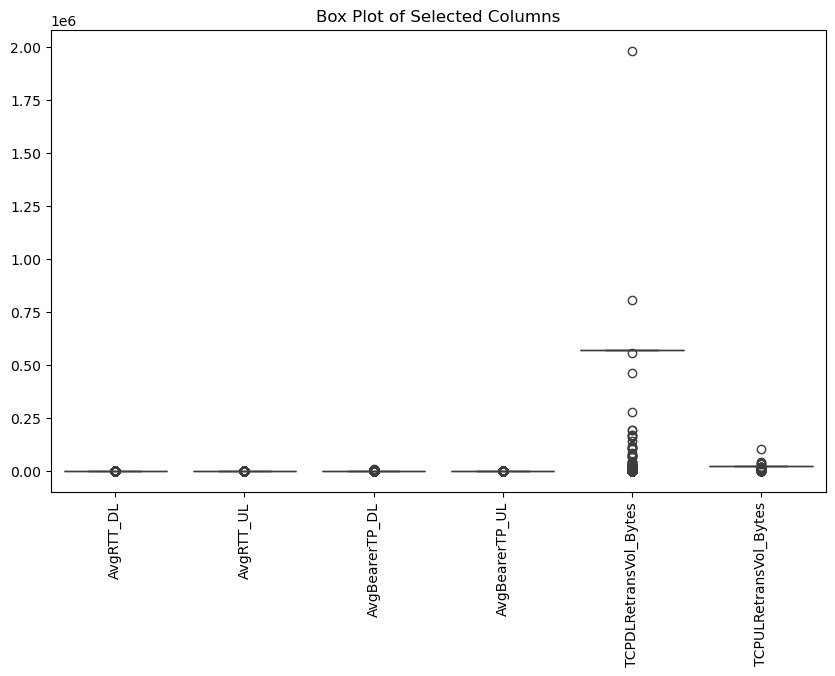

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_selected)
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.title('Box Plot of Selected Columns')
plt.show()

In [8]:
# Function to remove outliers
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


# Remove outliers
df = remove_outliers(df, df_selected)

df.head()
df.shape

(58008, 20)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58008 entries, 0 to 65570
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BearerId               58008 non-null  float64
 1   MSISDNNumber           58008 non-null  float64
 2   Duration_Seconds       58008 non-null  float64
 3   AvgRTT_DL              58008 non-null  float64
 4   AvgRTT_UL              58008 non-null  float64
 5   AvgBearerTP_DL         58008 non-null  float64
 6   AvgBearerTP_UL         58008 non-null  float64
 7   TCPDLRetransVol_Bytes  58008 non-null  float64
 8   TCPULRetransVol_Bytes  58008 non-null  float64
 9   GamingDL_Bytes         58008 non-null  float64
 10  YoutubeUL_Bytes        58008 non-null  float64
 11  YoutubeDL_Bytes        58008 non-null  float64
 12  NetflixUL_Bytes        58008 non-null  float64
 13  Total_Data             58008 non-null  float64
 14  Total_DL               58008 non-null  float64
 15  Total_U

####Aggregate, per customer,
●	Average TCP retransmission
●	Average RTT
●	Handset type
●	Average throughput


In [10]:
# Aggregate data per customer
df_aggregated = df.groupby('MSISDNNumber').agg({
    'TCPDLRetransVol_Bytes': 'mean',
    'TCPULRetransVol_Bytes': 'mean',
    'AvgRTT_DL': 'mean',
    'AvgRTT_UL': 'mean',
    'AvgBearerTP_DL': 'mean',
    'AvgBearerTP_UL': 'mean',
    'BearerId': 'first'  # Assuming BearerId corresponds to the handset type
}).reset_index()

# Calculate the required metrics
df_aggregated['Avg_TCP_Retransmission'] = (df_aggregated['TCPDLRetransVol_Bytes'] + df_aggregated['TCPULRetransVol_Bytes']) / 2
df_aggregated['Avg_RTT'] = (df_aggregated['AvgRTT_DL'] + df_aggregated['AvgRTT_UL']) / 2
df_aggregated['Avg_Throughput'] = (df_aggregated['AvgBearerTP_DL'] + df_aggregated['AvgBearerTP_UL']) / 2

# Select and display the relevant columns
df_result = df_aggregated[['MSISDNNumber', 'BearerId', 'Avg_TCP_Retransmission', 'Avg_RTT', 'Avg_Throughput']]
print(df_result.head())

   MSISDNNumber      BearerId  Avg_TCP_Retransmission  Avg_RTT  Avg_Throughput
0  3.360100e+10  1.311450e+19               294839.75     23.0            38.0
1  3.360100e+10  7.349880e+18               294839.75     15.5            49.5
2  3.360100e+10  7.349880e+18               294839.75     25.0            48.5
3  3.360101e+10  7.349880e+18               294839.75     14.0            31.5
4  3.360101e+10  7.349880e+18               294839.75     25.0            60.5



1.   RTT (Round Trip Time): The RTT values range from 14.0 ms to 25.0 ms. This variation indicates that the time taken for a signal to travel to the destination and back varies depending on the session, with some sessions experiencing quicker round-trip times than others. A lower RTT generally suggests a more responsive connection, while higher RTT values can indicate latency issues.
2.   Throughput and TCP Retransmission: The throughput values range from 31.5 to 60.5 Mbps, showing that different sessions experience varying data transfer rates. However, the consistent high TCP retransmission value of 294839.75 across all sessions suggests that there might be significant packet loss or network congestion, potentially impacting the overall data transmission efficiency despite the varying throughput.

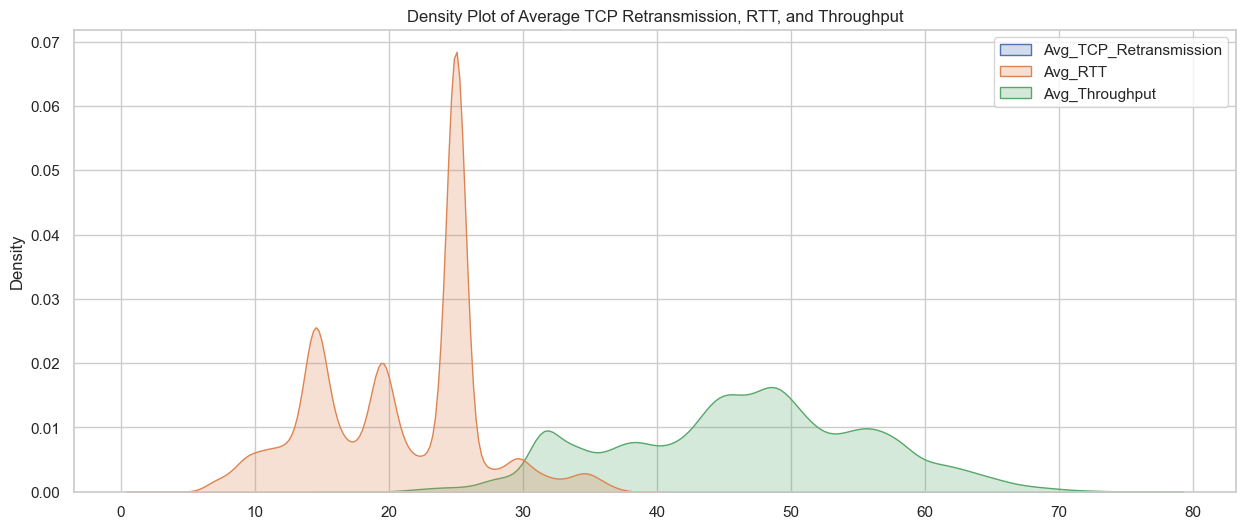

In [11]:
# Set the visual aesthetics
sns.set(style="whitegrid")

# Plot KDE for each metric
plt.figure(figsize=(15, 6))
sns.kdeplot(data=df_result[['Avg_TCP_Retransmission', 'Avg_RTT', 'Avg_Throughput']], fill=True)
plt.title('Density Plot of Average TCP Retransmission, RTT, and Throughput')
plt.show()


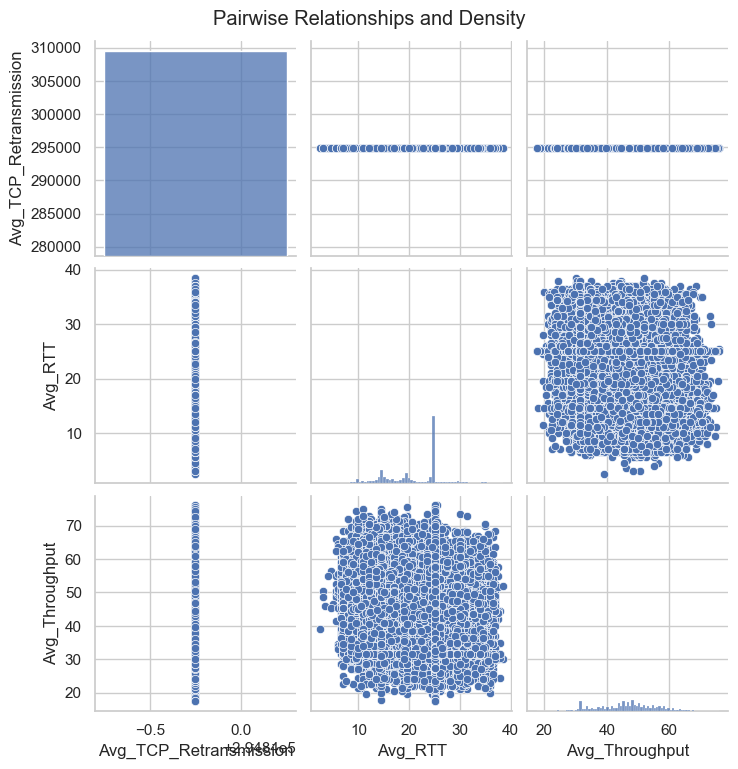

In [12]:

# Pairplot to show relationships and density
sns.pairplot(df_result[['Avg_TCP_Retransmission', 'Avg_RTT', 'Avg_Throughput']])
plt.suptitle('Pairwise Relationships and Density', y=1.02)
plt.show()

1.   Avg_TCP_Retransmission: Highly clustered, indicating little variation; may suggest consistent performance or data issues.
2.   Avg_RTT: Varied with specific peaks, reflecting diverse network conditions experienced by users.
1.   Avg_Throughput: Evenly distributed with some concentration; shows a broad range of user experiences.
2.   Pairwise Relationships: No clear correlations between metrics, suggesting they may operate independently.








### Top 10, Bottom 10, and Most Frequent for Avg_TCP_Retransmission

In [13]:

top_10_tcp = df_result.nlargest(10, 'Avg_TCP_Retransmission')
bottom_10_tcp = df_result.nsmallest(10, 'Avg_TCP_Retransmission')
most_frequent_tcp = df_result['Avg_TCP_Retransmission'].value_counts().head(10)

# Top 10, Bottom 10, and Most Frequent for Avg_RTT
top_10_rtt = df_result.nlargest(10, 'Avg_RTT')
bottom_10_rtt = df_result.nsmallest(10, 'Avg_RTT')
most_frequent_rtt = df_result['Avg_RTT'].value_counts().head(10)

# Top 10, Bottom 10, and Most Frequent for Avg_Throughput
top_10_throughput = df_result.nlargest(10, 'Avg_Throughput')
bottom_10_throughput = df_result.nsmallest(10, 'Avg_Throughput')
most_frequent_throughput = df_result['Avg_Throughput'].value_counts().head(10)



In [14]:
# Display the results
print("Top 10 TCP Retransmission Values: \n ",  top_10_tcp  )
print()

print("\nTop 10 RTT Values: \n", top_10_rtt)
print()

print("\nTop 10 Throughput Values:")
print(top_10_throughput)



Top 10 TCP Retransmission Values: 
     MSISDNNumber      BearerId  Avg_TCP_Retransmission  Avg_RTT  Avg_Throughput
0  3.360100e+10  1.311450e+19               294839.75     23.0            38.0
1  3.360100e+10  7.349880e+18               294839.75     15.5            49.5
2  3.360100e+10  7.349880e+18               294839.75     25.0            48.5
3  3.360101e+10  7.349880e+18               294839.75     14.0            31.5
4  3.360101e+10  7.349880e+18               294839.75     25.0            60.5
5  3.360101e+10  7.349880e+18               294839.75     25.0            53.0
6  3.360102e+10  7.349880e+18               294839.75     26.5            34.5
7  3.360103e+10  7.349880e+18               294839.75     25.0            49.0
8  3.360103e+10  7.349880e+18               294839.75     10.0            52.0
9  3.360103e+10  7.349880e+18               294839.75     25.0            28.0


Top 10 RTT Values: 
        MSISDNNumber      BearerId  Avg_TCP_Retransmission  Avg_RTT  \
2

In [15]:

print("\nBottom 10 TCP Retransmission Values:")
print(bottom_10_tcp)

print("\nBottom 10 RTT Values:")
print(bottom_10_rtt)


print("\nBottom 10 Throughput Values:")
print(bottom_10_throughput)




Bottom 10 TCP Retransmission Values:
   MSISDNNumber      BearerId  Avg_TCP_Retransmission  Avg_RTT  Avg_Throughput
0  3.360100e+10  1.311450e+19               294839.75     23.0            38.0
1  3.360100e+10  7.349880e+18               294839.75     15.5            49.5
2  3.360100e+10  7.349880e+18               294839.75     25.0            48.5
3  3.360101e+10  7.349880e+18               294839.75     14.0            31.5
4  3.360101e+10  7.349880e+18               294839.75     25.0            60.5
5  3.360101e+10  7.349880e+18               294839.75     25.0            53.0
6  3.360102e+10  7.349880e+18               294839.75     26.5            34.5
7  3.360103e+10  7.349880e+18               294839.75     25.0            49.0
8  3.360103e+10  7.349880e+18               294839.75     10.0            52.0
9  3.360103e+10  7.349880e+18               294839.75     25.0            28.0

Bottom 10 RTT Values:
       MSISDNNumber      BearerId  Avg_TCP_Retransmission  Avg_RTT  \


In [16]:
print("\nMost Frequent RTT Values:")
print(most_frequent_rtt)

print("\nMost Frequent Throughput Values:")
print(most_frequent_throughput)

print("\nMost Frequent TCP Retransmission Values:")
print(most_frequent_tcp)


Most Frequent RTT Values:
Avg_RTT
25.0    16846
14.5     3330
19.5     2414
15.0     1563
14.0     1555
19.0     1417
20.0     1254
15.5     1041
24.5      866
13.5      808
Name: count, dtype: int64

Most Frequent Throughput Values:
Avg_Throughput
31.5    2507
48.5    1416
45.0    1311
49.0    1289
48.0    1184
49.5    1165
45.5    1104
44.5    1070
44.0    1068
46.5    1066
Name: count, dtype: int64

Most Frequent TCP Retransmission Values:
Avg_TCP_Retransmission
294839.75    51159
Name: count, dtype: int64


###Throughput in networking refers to the rate at which data is successfully transmitted over a network. It's typically measured in bits per second (bps), kilobits per second (kbps), or megabits per second (Mbps).

Average Throughput is a metric that indicates the average amount of data transferred from one point to another within a specified time frame, typically over a network connection.

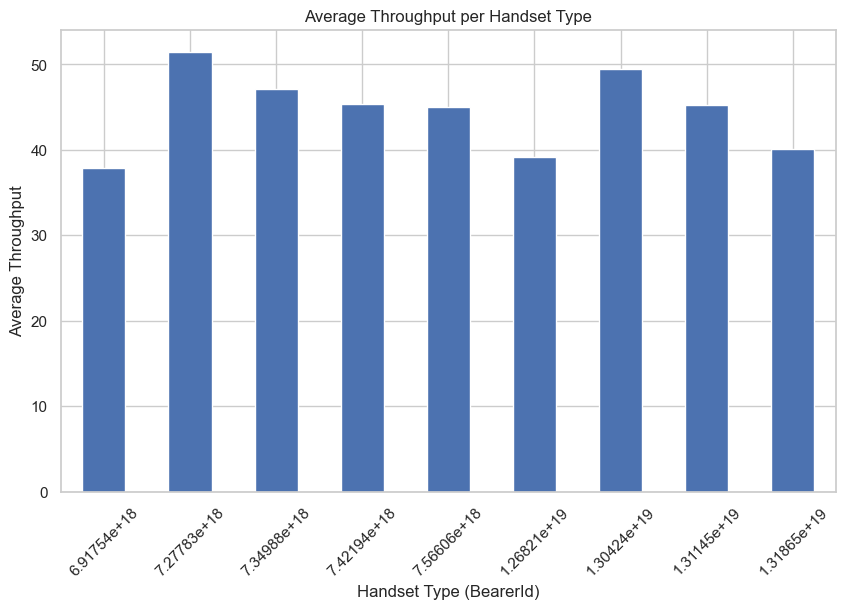

In [17]:
# Group by handset type (BearerId) and calculate the mean average throughput
throughput_distribution = df_result.groupby('BearerId')['Avg_Throughput'].mean()

throughput_distribution

# Plot the distribution as a bar chart
plt.figure(figsize=(10, 6))
throughput_distribution.plot(kind='bar')
plt.title('Average Throughput per Handset Type')
plt.xlabel('Handset Type (BearerId)')
plt.ylabel('Average Throughput')
plt.xticks(rotation=45)
plt.show()



1.   some handset types consistently show higher average throughput, it could indicate better network performance or more advanced technology in those handsets.
2.   Conversely, lower throughput could suggest either limitations in the device hardware or potentially poorer network conditions for users of those devices and network congestion, poor signal strength.

###Suggestion
*   A certain handset type consistently shows low throughput, operators might focus on improving network conditions or suggesting handset upgrades to users.
*   Monitoring throughput helps ensure that the network meets certain quality standards, providing a satisfactory user experience for applications like streaming, gaming, and video calls, which rely heavily on consistent and high throughput.




###TCP Retransmission
*   TCP (Transmission Control Protocol) is a core protocol of the Internet Protocol Suite that ensures reliable data transmission between a sender and receiver.
*   TCP Retransmission occurs when a packet of data fails to reach its destination or is not acknowledged by the receiver within a certain timeframe.


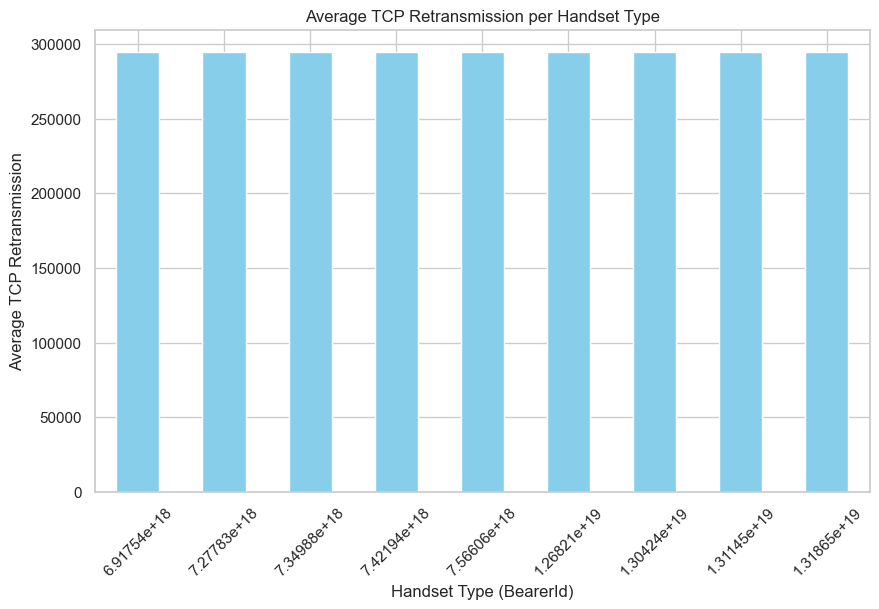

In [18]:
# Calculate the average TCP retransmission per handset type
tcp_retransmission_per_handset = df_result.groupby('BearerId')['Avg_TCP_Retransmission'].mean()

# Plot the results as a bar chart
plt.figure(figsize=(10, 6))
tcp_retransmission_per_handset.plot(kind='bar', color='skyblue')
plt.title('Average TCP Retransmission per Handset Type')
plt.xlabel('Handset Type (BearerId)')
plt.ylabel('Average TCP Retransmission')
plt.xticks(rotation=45)
plt.show()

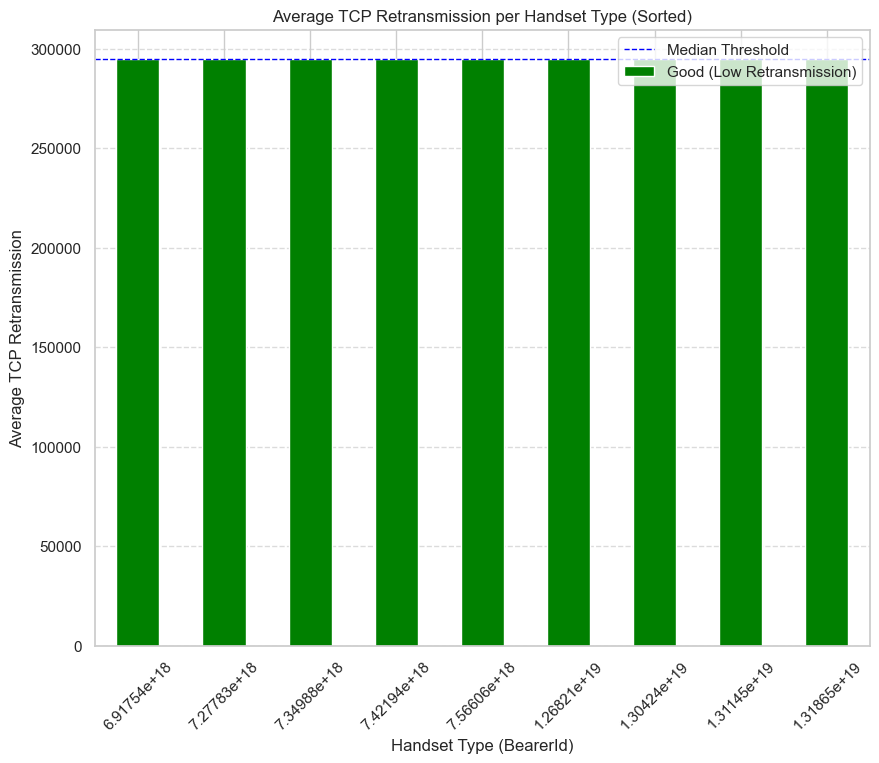

In [19]:

# Calculate the average TCP retransmission per handset type
tcp_retransmission_per_handset = df_result.groupby('BearerId')['Avg_TCP_Retransmission'].mean()

# Sort the values to display them from low to high retransmission rates
tcp_retransmission_per_handset_sorted = tcp_retransmission_per_handset.sort_values()

# Determine a threshold to classify good (low) and bad (high) retransmission rates
threshold = np.median(tcp_retransmission_per_handset_sorted)

# Color the bars based on whether they are above or below the threshold
colors = ['green' if value <= threshold else 'red' for value in tcp_retransmission_per_handset_sorted]

# Plot the results as a bar chart
plt.figure(figsize=(10, 8))
tcp_retransmission_per_handset_sorted.plot(kind='bar', color=colors)
plt.title('Average TCP Retransmission per Handset Type (Sorted)')
plt.xlabel('Handset Type (BearerId)')
plt.ylabel('Average TCP Retransmission')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend to indicate what green and red bars represent
plt.axhline(threshold, color='blue', linewidth=1, linestyle='--', label='Median Threshold')
plt.legend(['Median Threshold', 'Good (Low Retransmission)', 'Bad (High Retransmission)'], loc='upper right')

plt.show()

1.   X-Axis (Handset Type - BearerId):
2.   Y-Axis (Average TCP Retransmission):
3.   Bars (Green Color) Each green bar represents the average TCP retransmission rate for a specific handset type.
2.   Median Threshold (Blue Dashed Line): The blue dashed line represents the median threshold for TCP retransmission across all handset types.


*   **Uniform Performance:** This uniformity indicates that TCP retransmission is consistent, without significant variations between different devices.
*   **Threshold Comparison:** This proximity to the threshold implies a balanced network performance across all devices.

###**Potential Network Stability:**

1.   The consistent retransmission rates across handset types indicate a stable network environment.
2.   The lack of major outliers suggests that the network provides a similar quality of service to all handset models.




In [20]:
from sklearn.cluster import KMeans
# Select the relevant columns for clustering
df_clustering = df_aggregated[['Avg_TCP_Retransmission', 'Avg_RTT', 'Avg_Throughput']]

# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df_aggregated['Cluster'] = kmeans.fit_predict(df_clustering)

# Display cluster centers and counts
cluster_centers = kmeans.cluster_centers_
cluster_counts = df_aggregated['Cluster'].value_counts()

# Print results
print("Cluster Centers:\n", cluster_centers)
print("\nCluster Counts:\n", cluster_counts)

Cluster Centers:
 [[2.94839750e+05 1.46483692e+01 4.93244664e+01]
 [2.94839750e+05 2.48357380e+01 5.37904818e+01]
 [2.94839750e+05 2.26615050e+01 3.58688753e+01]]

Cluster Counts:
 Cluster
1    17912
2    17071
0    16176
Name: count, dtype: int64


  File "c:\Users\dewan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\dewan\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dewan\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\dewan\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


### Perform a k-means clustering (where k = 3) to segment users into groups of experiences

In [21]:
from mpl_toolkits.mplot3d import Axes3D

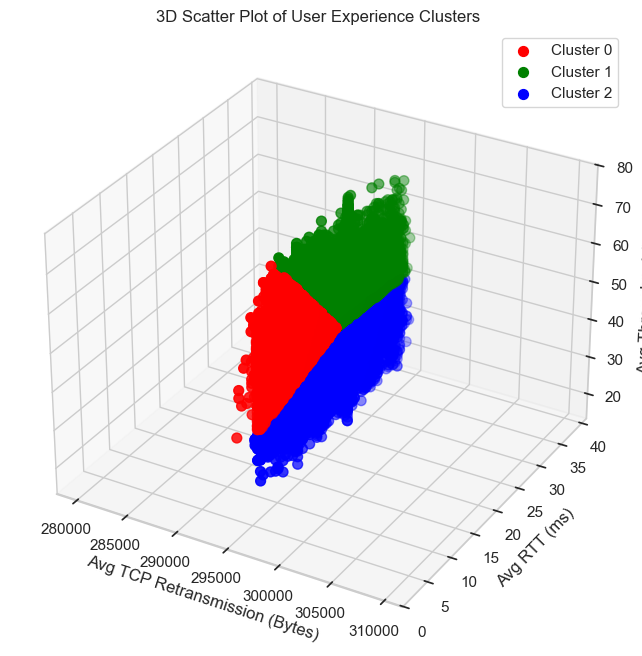

In [22]:

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a 3D scatter plot to visualize the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define the colors for each cluster
colors = ['red', 'green', 'blue']

# Plot each cluster
for cluster in range(3):
    cluster_data = df_aggregated[df_aggregated['Cluster'] == cluster]
    ax.scatter(cluster_data['Avg_TCP_Retransmission'],
               cluster_data['Avg_RTT'],
               cluster_data['Avg_Throughput'],
               c=colors[cluster],
               label=f'Cluster {cluster}',
               s=50)

# Set labels and title
ax.set_xlabel('Avg TCP Retransmission (Bytes)')
ax.set_ylabel('Avg RTT (ms)')
ax.set_zlabel('Avg Throughput (Mbps)')
ax.set_title('3D Scatter Plot of User Experience Clusters')

# Add a legend
ax.legend()

# Show the plot
plt.show()



1.   **Cluster 0** represents users with a more average network experience with moderate latency and lower data speeds. This cluster includes users with moderate latency and lower throughput, indicating a more average or slightly suboptimal network experience. Users in this cluster might experience slower data speeds and moderate delays in response times.


2.   **Cluster 1**consists of users with higher latency but better throughput, indicating that they can handle more data despite longer wait times. Users in this cluster experience higher latency but enjoy high throughput,which suggests that while their connections may have higher response times, they are capable of transmitting large amounts of data quickly once the connection is established.

3.   **Cluster 2** includes users who benefit from low latency and decent throughput, leading to a good overall experience.  This cluster is characterized by low latency and moderate throughput, offering a good balance between quick response times and fairly high data transmission rates. This suggests a generally satisfactory user experience with minimal delays.




